In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! cp kaggle.json ~/.kaggle/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets download -d julian3833/jigsaw-toxic-comment-classification-challenge

 96% 51.0M/53.4M [00:04<00:00, 15.4MB/s]
100% 53.4M/53.4M [00:04<00:00, 12.9MB/s]


In [13]:
! unzip /content/jigsaw-toxic-comment-classification-challenge.zip

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test_labels.csv         
  inflating: train.csv               


In [14]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_columns',None)

In [15]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [16]:
df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
58779,9d64a17cee3ad6f5,"hey punk dont be deleting my stuff, you know n...",1,0,1,0,1,1
135086,d290a08167571463,Deal with whatever definitions the critics use.,0,0,0,0,0,0
145899,23e965d0393c57b1,"""\n\nRead the """"Signing"""" section of the artic...",0,0,0,0,0,0
36252,60e1ece91f6ad088,^^^\nthink this scares me? what will they do. ...,1,0,0,0,0,0
70320,bc23bd6f52f74975,Thank you Betacommand. Much obliged.,0,0,0,0,0,0


In [17]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [18]:
df.iloc[4]['comment_text']

"You, sir, are my hero. Any chance you remember what page that's on?"

In [19]:
from tensorflow.keras.layers import TextVectorization

In [20]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [21]:
MAX_WORDS = 200000 #number of words in the vocabualry

In [22]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS,
                               output_sequence_length=1800,
                               output_mode='int')

In [23]:
vectorizer.adapt(X.values)

In [24]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [25]:
vectorized_text = vectorizer(X.values) 

In [26]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [27]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [28]:
print(batch_X.shape, batch_y.shape)

(16, 1800) (16, 6)


In [29]:
len(dataset)

9974

In [30]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [31]:
len(train)

6981

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [33]:
model = Sequential()
model.add(Embedding(MAX_WORDS+1, 32))

model.add(Bidirectional(LSTM(32, activation='tanh')))

model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
  
model.add(Dense(6, activation='sigmoid'))


In [34]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [36]:
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 797s 113ms/step - loss: 0.0620 - val_loss: 0.0442
Epoch 2/10
6981/6981 [==============================] - 650s 93ms/step - loss: 0.0460 - val_loss: 0.0395
Epoch 3/10
6981/6981 [==============================] - 667s 96ms/step - loss: 0.0403 - val_loss: 0.0375
Epoch 4/10
6981/6981 [==============================] - 640s 92ms/step - loss: 0.0358 - val_loss: 0.0311
Epoch 5/10
6981/6981 [==============================] - 659s 94ms/step - loss: 0.0321 - val_loss: 0.0266
Epoch 6/10
6981/6981 [==============================] - 664s 95ms/step - loss: 0.0286 - val_loss: 0.0254
Epoch 7/10
6981/6981 [==============================] - 636s 91ms/step - loss: 0.0257 - val_loss: 0.0242
Epoch 8/10
6981/6981 [==============================] - 625s 90ms/step - loss: 0.0230 - val_loss: 0.0204
Epoch 9/10
6981/6981 [==============================] - 622s 89ms/step - loss: 0.0208 - val_loss: 0.0185
Epoch 10/10
6981/6981 [==============================]

<Figure size 2000x2000 with 0 Axes>

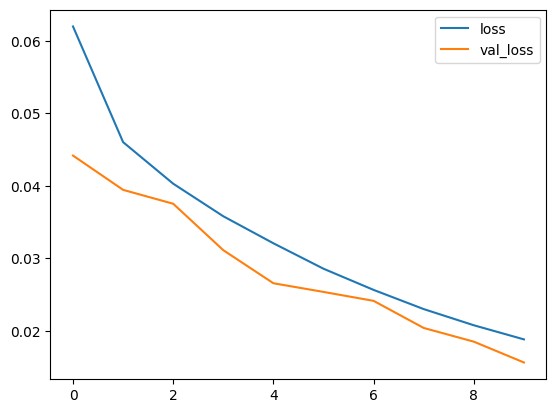

In [37]:
plt.figure(figsize=(20,20))
pd.DataFrame(hist.history).plot()
plt.show()


In [38]:
input_text = vectorizer('You freaking suck!')

In [39]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 1s/step


In [40]:
res

array([[0.99956995, 0.33142307, 0.99522203, 0.01219919, 0.93095   ,
        0.01893665]], dtype=float32)

In [41]:
batch = test.as_numpy_iterator().next()

In [42]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [43]:
(model.predict(batch_X) >0.5).astype(int)

1/1 [==============================] - 0s 65ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [44]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [45]:
pre =Precision()
re = Recall()
acc = CategoricalAccuracy()

In [46]:
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    
    yhat = model.predict(X_true)
    
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)    
    acc.update_state(y_true, yhat) 

1/1 [==============================] - 0s 79ms/step


In [47]:
print('Precision = {}, Recall = {}, Accuracy = {}'.format(pre.result().numpy(),re.result().numpy(),acc.result().numpy()))

Precision = 0.9193594455718994, Recall = 0.9193594455718994, Accuracy = 0.4964894652366638


In [48]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text +='{}: {}\n'.format(col, results[0][idx]>0.5)
        
    return text

In [49]:
comment = 'I freaking hate you'
print(score_comment(comment))

1/1 [==============================] - 0s 55ms/step
toxic: True
severe_toxic: False
obscene: False
threat: False
insult: True
identity_hate: False



In [50]:
comment = 'I love you'
print(score_comment(comment))

1/1 [==============================] - 0s 52ms/step
toxic: False
severe_toxic: False
obscene: False
threat: False
insult: False
identity_hate: False



In [51]:
comment = 'I will kill you'
print(score_comment(comment))

1/1 [==============================] - 0s 51ms/step
toxic: True
severe_toxic: False
obscene: False
threat: True
insult: False
identity_hate: False



In [52]:
model.save('toxic_text_classification.h5')